In [1]:
import pandas as pd
import csv
import re
import warnings
import time 
warnings.filterwarnings('ignore')
begin_starting_time = time.time()

In [2]:
file = "big_df_v2.csv"  #large file for production
#file = "small_R_df.csv"       #small file for development
df = pd.read_csv('private/'+file, delimiter='|', encoding='latin-1')

In [3]:
#### stripping HTML tags ####
p = '<.*?>'
for col in df.columns:
    df[col] = df[col].replace(p, '', regex=True)

In [4]:
# splitting categories into main and sub, dropping non-Book main categories #
regex = r"\/(.*?)\/.*"

df['sub_cat'] = df['categoryPath'].str.extract(regex) # sub categories, one level below Books.
df['main_cat'] = df['categoryPath'].astype(str).str[:5] 
df = df[df.main_cat == 'Books'] #dropping non-Book categories

# drop rows missing critical data #
df = df.dropna(axis=0, how='any', subset=['longDn', 'sub_cat','name'])
df.isnull().sum().sort_values(ascending=False)

model           247144
parentItemId      3974
itemId            3515
shortDn            204
main_cat             0
sub_cat              0
catNode              0
longDn               0
categoryPath         0
name                 0
dtype: int64

In [5]:
print("There are " + str(len(df.sub_cat.value_counts())) + " categories of books.")
counts = df['sub_cat'].value_counts()
threshold = 100
print(str(len(counts[counts>threshold])) + " categories have more than " + str(threshold) +" books.")

There are 74 categories of books.
56 categories have more than 100 books.


In [6]:
Top_40_cats = df.sub_cat.value_counts().iloc[:39].index.tolist()

# Print number of titles represented in each of the Top 40 categories #
print(df.sub_cat.value_counts().iloc[:39])


Business & Money Books                      20783
Children's & Kids' Books                    19813
Medical Books                               19255
History Books                               16745
Education Books                             14129
Computers & Technology Books                12787
Law Books                                   11642
Biographies & Memoirs                       10261
Sports & Outdoor Books                      10054
Political Books                              9292
Language Arts & Disciplines Books            7501
Self-Help Books                              7103
Health & Wellness Books                      6852
Crafts & Hobbies Books                       6475
Mathematics Books                            6388
Philosophy Books                             6114
Travel Books                                 5810
Reference Books                              5681
Foreign Language Study & Reference Books     5561
Teen & Young Adult Books                     5358


In [7]:
# Only keep records for top n populated categories (drop sparsely populated categories) #
df = df.loc[df['sub_cat'].isin(Top_40_cats)]

# Preparing Corpus and BOW for LDA Topic Modeling with Gensim
#### references used:
> http://mallet.cs.umass.edu/  
> https://radimrehurek.com/gensim/models/ldamodel.html  
> https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
> https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

In [8]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk#; nltk.download('stopwords')
#!python3 -m spacy download en

In [9]:
import numpy as np
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Fancy LDA visualization tool
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable gensim logging 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['book'])
#stop_words.extend(['book', 'new']) # decided extra stop words could be introducing bias 

In [11]:
# reviewing unique categories #
print(df.sub_cat.unique())

['Arts & Entertainment Books' "Children's & Kids' Books"
 'Business & Money Books' 'Cookbooks, Food & Wine'
 'Crafts & Hobbies Books' 'Literature & Fiction Books'
 'Religion & Spirituality Books' 'Dieting & Fitness Books'
 'Study Aids & Test Prep Books' 'Health & Wellness Books'
 'Biographies & Memoirs' 'Reference Books' 'Humor Books'
 'Libros en Espanol' 'Computers & Technology Books'
 'Comic Books & Graphic Novels' 'Teen & Young Adult Books' 'Medical Books'
 'Self-Help Books' 'History Books' 'True Crime Books'
 'Psychology & Social Science Books' 'House, Home & Gardening Books'
 'Travel Books' 'Education Books' 'Engineering & Transportation Books'
 'Science & Nature Books' 'Language Arts & Disciplines Books' 'Law Books'
 'Foreign Language Study & Reference Books' 'Mathematics Books'
 'Political Books' 'Philosophy Books' 'Sports & Outdoor Books'
 'Language Arts & Disciplines' 'Business & Money' 'Nonfiction' 'History'
 'Law']


In [12]:
data = df.longDn.values.tolist()

In [13]:
# converting contractions
data = [re.sub("won't","will not", sent) for sent in data]
data = [re.sub("can't","can not", sent) for sent in data]
data = [re.sub("n't","not", sent) for sent in data]
data = [re.sub("\'ll"," will", sent) for sent in data]
data = [re.sub("\'re"," are", sent) for sent in data]
data = [re.sub("\'ve"," have", sent) for sent in data]

# removing any single quotes
data = [re.sub("\'", " ", sent) for sent in data] 
# removing pipes to help with saving csv as pipe-delimited
data = [re.sub("\|", " ", sent) for sent in data]
# leave only letters and numbers (makes above lines redundant, but that's ok)
data = [re.sub("[^a-zA-Z0-9 ]", " ", sent) for sent in data]
# removing any extraneous spaces
data = [re.sub("\s+", " ", sent) for sent in data] #strip extra spaces

<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence \|
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:12: DeprecationWarning: invalid escape sequence 

In [14]:
# random check to ensure clean data
data[300]

'Robust DC Comics Roster Engage in epic match ups with a massive roster of DC Comics heroes and villains including Batman Cyborg The Flash Harley Quinn Nightwing Solomon Grundy Superman and Wonder Woman Master God Like Powers Unleash each character s unique super powers with individual move sets and environmental interactions Uncontainable Battles Fight through multi tiered fighting arenas by hurling opponents through buildings and launching them off cliffs Original DC Comics Saga Set in Iconic Environments Experience an authentic DC Comics storyline created in collaboration between NetherRealm Studios DC Entertainment and writers Justin Gray and Jimmy Palmiotti Players will discover and do battle in numerous iconic locales pulled from DC Comics lore Destructive Fighter in which the World is a Weapon Experience epic battles on a massive scale as players control the most powerful beings in the universe in destructible interactive environments Destroy elements of the world and use super 

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [16]:
# Build the bigrams and trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [17]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [18]:
starting_time = time.time()
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:4])
ending_time = time.time()
print(ending_time-starting_time)

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
C:\ProgramData\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])


1943.9870743751526


In [19]:
starting_time = time.time()

id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
ending_time = time.time()
print(ending_time-starting_time)

37.75881052017212


# How many topics should we train? 

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA multiecore models
    coherence_values : Coherence values corresponding to the LDA multicore model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


"""    
    Warning: This WILL take a while 
"""
starting_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

ending_time = time.time()
print(ending_time-starting_time)



1260.0190606117249


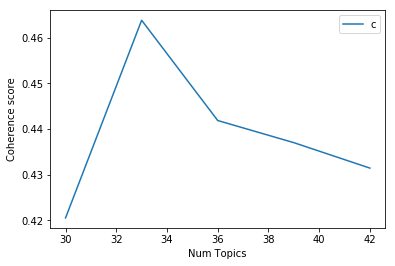

Num Topics = 30  has Coherence Value of 0.4206
Num Topics = 33  has Coherence Value of 0.4638
Num Topics = 36  has Coherence Value of 0.4419
Num Topics = 39  has Coherence Value of 0.437
Num Topics = 42  has Coherence Value of 0.4315


In [21]:
# Show graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [22]:
############################################################
# comparing LDA model coherence scores vs. LDA Multicore
############################################################
#  As expected (and unexplained) LDA Model performs better
#  than the LDA multicore model with identical parameters 
############################################################


def compute_coherence_values(dictionary, corpus, texts, limit, start=20, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

"""    
    Warning: This WILL take a while 
"""
starting_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=30, limit=45, step=3)

ending_time = time.time()
print(ending_time-starting_time)



2636.402649641037


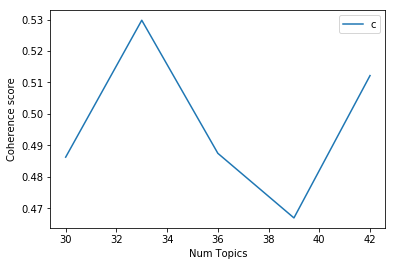

Num Topics = 30  has Coherence Value of 0.4862
Num Topics = 33  has Coherence Value of 0.5298
Num Topics = 36  has Coherence Value of 0.4875
Num Topics = 39  has Coherence Value of 0.4669
Num Topics = 42  has Coherence Value of 0.5122


In [23]:
# print graph
limit=45; start=30; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


#          LDA Multicore results:   
big_df  
>  Num Topics = 30  has Coherence Value of 0.4437  
>  Num Topics = 33  has Coherence Value of 0.4106  
>  Num Topics = 36  has Coherence Value of 0.4513  
>  Num Topics = 39  has Coherence Value of 0.4462  
>  Num Topics = 42  has Coherence Value of 0.4425   

bigger_df:   
> Num Topics = 30  has Coherence Value of 0.4466  
> Num Topics = 33  has Coherence Value of 0.4341  
> Num Topics = 36  has Coherence Value of 0.4334  
> Num Topics = 39  has Coherence Value of 0.4356  
> Num Topics = 42  has Coherence Value of 0.4412  

#            LDA Model results:   
big_df  
> Num Topics = 30  has Coherence Value of 0.5116  
> Num Topics = 33  has Coherence Value of 0.5101  
> Num Topics = 36  has Coherence Value of 0.5146  
> Num Topics = 39  has Coherence Value of 0.4696  
>  Num Topics = 42  has Coherence Value of 0.4832  
 
bigger_df:  
> Num Topics = 30  has Coherence Value of 0.5535  
> Num Topics = 33  has Coherence Value of 0.4843  
> Num Topics = 36  has Coherence Value of 0.4783  
> Num Topics = 39  has Coherence Value of 0.4902  
> Num Topics = 42  has Coherence Value of 0.4779  
      
  As expected (and unexplained) LDA Model performs better   
  than the LDA multicore model with identical parameters   



# Attempting high score: Topics: 30, chunks: 50k, passes=20

> New Best Model? Yes  
> Runtime: 1 hour (3439 seconds)   
> Perplexity: -8.6129  
> Coherence Score: 0.6238   

added 'new' as stopword, coherence dropped to 0.603. Decision reversed.


In [24]:
starting_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=20,
                                           per_word_topics=True)
ending_time = time.time()
print(ending_time-starting_time)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
ending_time = time.time()
print(ending_time-starting_time)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

ending_time = time.time()
print(ending_time-starting_time)
vis

2766.9215009212494

Perplexity:  -8.612855951277107

Coherence Score:  0.6238443153837738
3032.455468893051


C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning: invalid escape sequence \d
  nbits = re.compile('(\d+)bit').search(abits).group(1)
C:\ProgramData\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning: invalid escape sequence \s
  "\s+stepping\s+(?P<STP>\d+)", re.IGNORECASE)


3330.0570023059845


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
8      7.682620        1       1  0.126162  0.239113
3      7.388878        1       2  0.165959  0.150445
22     7.111084        1       3  0.146858 -0.090109
10     6.815186        1       4  0.182992 -0.100506
12     5.872808        1       5  0.087727  0.151839
0      4.238932        1       6  0.149670  0.073922
16     4.234859        1       7  0.189327 -0.006779
28     4.019387        1       8  0.157192 -0.134620
11     3.931979        1       9  0.051643  0.005187
27     3.791888        1      10  0.098213 -0.186942
1      3.734640        1      11  0.034762  0.192058
17     3.716907        1      12  0.129531 -0.079662
26     3.531607        1      13  0.129676 -0.221151
4      3.527565        1      14  0.047120  0.227218
29     3.164878        1      15  0.053542 -0.013633
20     3.153921        1      16  0.127904 -0.009411
9      3.033213        1      17  0.059124  0.169573
7      3.004684        1      18 -0.249167 -0.016576
14     2.919939        1      19  0.052432 -0.238921
19     2.470753        1      20 -0.054485  0.203573
5      2.171161        1      21  0.061425 -0.008270
13     2.068492        1      22  0.077294 -0.140900
6      1.657809        1      23 -0.139351 -0.017488
23     1.454538        1      24 -0.272762 -0.032133
24     1.449684        1      25 -0.269949 -0.026736
25     1.173729        1      26 -0.169214 -0.036334
21     0.926008        1      27 -0.184771 -0.025649
15     0.716696        1      28 -0.205380 -0.002906
18     0.556126        1      29 -0.299445 -0.017824
2      0.480039        1      30 -0.284028 -0.006379, topic_info=       Category          Freq                 Term         Total  loglift  \
term                                                                        
586     Default  46352.000000                 work  46352.000000  30.0000   
376     Default  28361.000000              student  28361.000000  29.0000   
1696    Default  12906.000000                  law  12906.000000  28.0000   
76      Default  41097.000000                guide  41097.000000  27.0000   
556     Default  19509.000000             question  19509.000000  26.0000   
861     Default  23034.000000             business  23034.000000  25.0000   
11      Default  18729.000000              edition  18729.000000  24.0000   
155     Default  52982.000000                 life  52982.000000  23.0000   
595     Default  23170.000000                child  23170.000000  22.0000   
849     Default  13914.000000                 test  13914.000000  21.0000   
713     Default  35834.000000                learn  35834.000000  20.0000   
10026   Default  13146.000000                  und  13146.000000  19.0000   
526     Default  25582.000000              history  25582.000000  18.0000   
775     Default  33754.000000                story  33754.000000  17.0000   
84      Default  16522.000000             language  16522.000000  16.0000   
828     Default  24008.000000             practice  24008.000000  15.0000   
697     Default  11491.000000                 food  11491.000000  14.0000   
10022   Default  11942.000000                  der  11942.000000  13.0000   
673     Default  15074.000000                 word  15074.000000  12.0000   
389     Default  20830.000000                 book  20830.000000  11.0000   
845     Default  20941.000000                study  20941.000000  10.0000   
82      Default  54174.000000              include  54174.000000   9.0000   
1539    Default  13996.000000                  die  13996.000000   8.0000   
728     Default   8863.000000               recipe   8863.000000   7.0000   
128     Default  47977.000000                  use  47977.000000   6.0000   
169     Default  16252.000000               school  16252.000000   5.0000   
1231    Default  15822.000000                 part  15822.000000   4.0000   
77      Default  38704.00000

# Attempting new high score: Topics: 30, chunks: 50k, passes=50

> New Best Model? Yes. Marginal improvement in Coherence Score (0.0034) by increasing from 20 to 50 passes.  
> Runtime: unclocked.   
> Perplexity: -8.609     
> Coherence Score: 0.6272     

added stopword 'new' and coherence decreased to 0.6078. Decision reversed.

In [25]:
starting_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
ending_time = time.time()
print(ending_time-starting_time)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
ending_time = time.time()
print(ending_time-starting_time)


6765.563163757324

Perplexity:  -8.60946785470689

Coherence Score:  0.6272157809690225
7079.421555995941


In [26]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

ending_time = time.time()
pyLDAvis.save_html(vis,'vis_2.html')
print(ending_time-starting_time)
vis


7440.919976472855


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
3      7.359968        1       1 -0.160913  0.161579
22     7.092208        1       2 -0.150000 -0.072863
8      6.923338        1       3 -0.110575  0.248840
10     6.521215        1       4 -0.180904 -0.099966
12     5.707232        1       5 -0.079609  0.170921
0      5.664420        1       6 -0.161287  0.084574
11     3.981361        1       7 -0.051736  0.013022
28     3.972414        1       8 -0.158206 -0.121917
4      3.956272        1       9 -0.048732  0.223989
16     3.936177        1      10 -0.186449 -0.026343
27     3.721872        1      11 -0.104374 -0.179770
1      3.653440        1      12 -0.019241  0.182938
26     3.589926        1      13 -0.146227 -0.209929
17     3.551452        1      14 -0.114267 -0.076718
14     3.388958        1      15 -0.073442 -0.228466
29     3.264809        1      16 -0.066538 -0.015672
7      3.004112        1      17  0.244536 -0.022056
9      2.910925        1      18 -0.049540  0.173302
20     2.716130        1      19 -0.109337 -0.032085
19     2.414322        1      20  0.075881  0.184943
5      2.115396        1      21 -0.057489 -0.000422
13     2.021766        1      22 -0.074040 -0.143642
6      1.765982        1      23  0.115614 -0.028262
24     1.454381        1      24  0.263444 -0.034589
23     1.450595        1      25  0.266755 -0.039969
25     1.204378        1      26  0.167777 -0.033316
21     0.924534        1      27  0.179382 -0.027958
15     0.701789        1      28  0.211394 -0.007833
18     0.556546        1      29  0.295633 -0.026749
2      0.474089        1      30  0.282492 -0.015582, topic_info=       Category          Freq            Term         Total  loglift  logprob
term                                                                         
586     Default  46303.000000            work  46303.000000  30.0000  30.0000
376     Default  28575.000000         student  28575.000000  29.0000  29.0000
76      Default  41113.000000           guide  41113.000000  28.0000  28.0000
1696    Default  12899.000000             law  12899.000000  27.0000  27.0000
861     Default  21978.000000        business  21978.000000  26.0000  26.0000
556     Default  19525.000000        question  19525.000000  25.0000  25.0000
11      Default  18544.000000         edition  18544.000000  24.0000  24.0000
155     Default  52282.000000            life  52282.000000  23.0000  23.0000
84      Default  16499.000000        language  16499.000000  22.0000  22.0000
713     Default  36146.000000           learn  36146.000000  21.0000  21.0000
595     Default  23374.000000           child  23374.000000  20.0000  20.0000
849     Default  13907.000000            test  13907.000000  19.0000  19.0000
526     Default  25837.000000         history  25837.000000  18.0000  18.0000
775     Default  33598.000000           story  33598.000000  17.0000  17.0000
10026   Default  13088.000000             und  13088.000000  16.0000  16.0000
673     Default  14736.000000            word  14736.000000  15.0000  15.0000
828     Default  24014.000000        practice  24014.000000  14.0000  14.0000
82      Default  54235.000000         include  54235.000000  13.0000  13.0000
845     Default  20948.000000           study  20948.000000  12.0000  12.0000
10022   Default  11889.000000             der  11889.000000  11.0000  11.0000
389     Default  20756.000000            book  20756.000000  10.0000  10.0000
697     Default  11245.000000            food  11245.000000   9.0000   9.0000
1539    Default  13905.000000             die  13905.000000   8.0000   8.0000
128     Default  48244.000000             use  48244.000000   7.0000   7.0000
728     Default   9310.000000          recipe   9310.000000   6.0000   6.0000
22      Default  55841.000000             new  55841.000000   5.0000   5.0000
169     Default  16540.000000          school  16540.000000   4.0000   4.0000

# trying same best model, separate random state (100 -> 200)
Before:  
> Runtime: 3hrs 25 minutes (12,209 seconds).   
> Perplexity: -8.609     
> Coherence Score: 0.6272    
 
After (random state changed to 200):  
> Runtime: 2hrs 15min (8,111 seconds)  
> Perplexity: -8.603    
> Coherence Score: 0.611      

Results: Similar score, no improvement.

In [27]:
starting_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=200,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
ending_time = time.time()
print(ending_time-starting_time)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
ending_time = time.time()
print(ending_time-starting_time)


7696.674213886261

Perplexity:  -8.60297614881278

Coherence Score:  0.610765605167509
7974.33885383606


In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

ending_time = time.time()
print(ending_time-starting_time)
vis
pyLDAvis.save_html(vis,'vis30.html')

8278.0778465271


In [29]:
# applying topics to docs in corpus
#lda_corpus = lda_model[corpus]


In [30]:
# Printing total runtime. Only relevant on full run. #
final_ending_time = time.time()
print(final_ending_time - begin_starting_time)

25434.2525267601


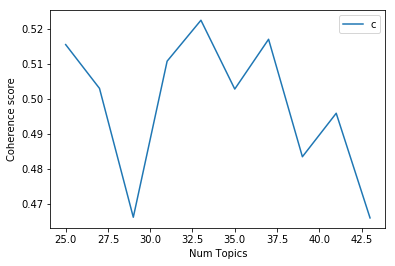

Num Topics = 25  has Coherence Value of 0.5154
Num Topics = 27  has Coherence Value of 0.5029
Num Topics = 29  has Coherence Value of 0.4661
Num Topics = 31  has Coherence Value of 0.5107
Num Topics = 33  has Coherence Value of 0.5224
Num Topics = 35  has Coherence Value of 0.5027
Num Topics = 37  has Coherence Value of 0.5169
Num Topics = 39  has Coherence Value of 0.4834
Num Topics = 41  has Coherence Value of 0.4958
Num Topics = 43  has Coherence Value of 0.4659


In [31]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=25, limit=45, step=2)

start=25; limit=45; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [32]:
starting_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=33, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
ending_time = time.time()
print(ending_time-starting_time)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
ending_time = time.time()
print(ending_time-starting_time)


7008.616668462753

Perplexity:  -8.6221415613218

Coherence Score:  0.5947213890407111
7286.701593399048


In [33]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

ending_time = time.time()
pyLDAvis.save_html(vis,'vis_33.html')
print(ending_time-starting_time)
vis


7602.087227344513


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
22     7.538398        1       1 -0.192771  0.065500
3      7.475779        1       2 -0.201144 -0.143988
10     7.153372        1       3 -0.217319  0.108911
20     7.084045        1       4 -0.217403 -0.075192
12     6.580778        1       5 -0.158694 -0.189526
28     6.424376        1       6 -0.213974  0.195105
4      6.378390        1       7 -0.140698 -0.241801
8      6.272828        1       8 -0.141559 -0.267776
27     3.966551        1       9 -0.145555  0.186101
29     3.829636        1      10 -0.134568  0.040850
32     3.514164        1      11 -0.086849 -0.069742
17     3.394252        1      12 -0.142816  0.152459
7      2.974541        1      13  0.191044  0.008111
16     2.970156        1      14 -0.177428  0.023648
1      2.752735        1      15 -0.088465 -0.058852
23     2.195592        1      16  0.206506  0.008238
13     2.049967        1      17 -0.098085  0.164207
9      2.007638        1      18  0.002305 -0.094113
15     1.941931        1      19  0.012122  0.080133
6      1.931746        1      20 -0.009328  0.002850
26     1.674397        1      21 -0.009057  0.145340
19     1.406400        1      22  0.151795 -0.152273
0      1.396788        1      23 -0.028417  0.012682
5      1.035792        1      24  0.080158  0.020291
25     0.973356        1      25  0.156544  0.037381
31     0.926716        1      26  0.145521  0.038390
11     0.760931        1      27  0.183295 -0.036363
21     0.723620        1      28  0.103750 -0.012052
18     0.677393        1      29  0.235704  0.009168
14     0.657738        1      30  0.192147  0.056880
30     0.459372        1      31  0.231252 -0.016188
24     0.445817        1      32  0.260588  0.003808
2      0.424801        1      33  0.251401 -0.002187, topic_info=       Category          Freq                  Term         Total  loglift  \
term                                                                         
586     Default  46324.000000                  work  46324.000000  30.0000   
675     Default  28738.000000                 write  28738.000000  29.0000   
22      Default  55752.000000                   new  55752.000000  28.0000   
376     Default  28973.000000               student  28973.000000  27.0000   
11      Default  18707.000000               edition  18707.000000  26.0000   
1696    Default  13048.000000                   law  13048.000000  25.0000   
84      Default  16293.000000              language  16293.000000  24.0000   
155     Default  52546.000000                  life  52546.000000  23.0000   
76      Default  41096.000000                 guide  41096.000000  22.0000   
556     Default  19674.000000              question  19674.000000  21.0000   
526     Default  25851.000000               history  25851.000000  20.0000   
861     Default  21807.000000              business  21807.000000  19.0000   
673     Default  14483.000000                  word  14483.000000  18.0000   
849     Default  13983.000000                  test  13983.000000  17.0000   
82      Default  54335.000000               include  54335.000000  16.0000   
713     Default  36023.000000                 learn  36023.000000  15.0000   
828     Default  24032.000000              practice  24032.000000  14.0000   
10026   Default  13109.000000                   und  13109.000000  13.0000   
128     Default  48204.000000                   use  48204.000000  12.0000   
595     Default  23106.000000                 child  23106.000000  11.0000   
243     Default  28718.000000                   get  28718.000000  10.0000   
845     Default  20935.000000                 study  20935.000000   9.0000   
389     Default  20625.000000                  book  20625.000000   8.0000   
77      Default  38614.000000                  help  38614.000000   7.0000   
10022   Default  11908.000000                   der  11908.000000   6.0000

In [34]:
starting_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)
ending_time = time.time()
print(ending_time-starting_time)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
ending_time = time.time()
print(ending_time-starting_time)


6474.00859951973

Perplexity:  -8.622156314066975

Coherence Score:  0.5991849708042652
6725.278758525848


In [35]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

ending_time = time.time()
pyLDAvis.save_html(vis,'vis_25.html')
print(ending_time-starting_time)
vis


7007.965141534805


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
22     10.225250        1       1  0.162381  0.127346
20      8.460344        1       2  0.180128 -0.021134
12      6.833489        1       3  0.123409 -0.097751
3       6.583010        1       4  0.171450 -0.117247
4       6.506839        1       5  0.113694 -0.212242
10      5.652650        1       6  0.112820  0.211707
8       5.293816        1       7  0.107330 -0.235786
5       4.901776        1       8  0.131063  0.189459
11      4.803076        1       9  0.087027  0.112913
19      4.797025        1      10  0.064595 -0.216473
0       4.643035        1      11  0.081124  0.005518
17      4.240025        1      12  0.139459  0.041564
1       4.211583        1      13  0.071799 -0.108131
14      3.678956        1      14  0.076460  0.251376
9       3.337100        1      15  0.079694 -0.153742
7       3.080100        1      16 -0.262501 -0.008342
23      2.508988        1      17 -0.281251 -0.006963
13      2.289267        1      18  0.042436  0.179452
15      1.516269        1      19 -0.099980  0.133974
24      1.400920        1      20 -0.062028  0.032268
16      1.214299        1      21 -0.059535 -0.044075
21      1.042614        1      22 -0.190433 -0.001585
6       1.022436        1      23 -0.238670 -0.022699
2       1.007272        1      24 -0.248698 -0.035412
18      0.749863        1      25 -0.301772 -0.003997, topic_info=      Category          Freq              Term         Total  loglift  logprob
term                                                                          
586    Default  46054.000000              work  46054.000000  30.0000  30.0000
76     Default  41328.000000             guide  41328.000000  29.0000  29.0000
376    Default  29276.000000           student  29276.000000  28.0000  28.0000
84     Default  16024.000000          language  16024.000000  27.0000  27.0000
155    Default  52386.000000              life  52386.000000  26.0000  26.0000
556    Default  19542.000000          question  19542.000000  25.0000  25.0000
775    Default  33414.000000             story  33414.000000  24.0000  24.0000
849    Default  14138.000000              test  14138.000000  23.0000  23.0000
713    Default  36272.000000             learn  36272.000000  22.0000  22.0000
828    Default  23805.000000          practice  23805.000000  21.0000  21.0000
10026  Default  13074.000000               und  13074.000000  20.0000  20.0000
673    Default  14284.000000              word  14284.000000  19.0000  19.0000
82     Default  54409.000000           include  54409.000000  18.0000  18.0000
845    Default  20914.000000             study  20914.000000  17.0000  17.0000
595    Default  23428.000000             child  23428.000000  16.0000  16.0000
128    Default  48771.000000               use  48771.000000  15.0000  15.0000
10022  Default  11876.000000               der  11876.000000  14.0000  14.0000
191    Default   9474.000000              game   9474.000000  13.0000  13.0000
77     Default  38669.000000              help  38669.000000  12.0000  12.0000
243    Default  28622.000000               get  28622.000000  11.0000  11.0000
697    Default  10853.000000              food  10853.000000  10.0000  10.0000
1539   Default  13930.000000               die  13930.000000   9.0000   9.0000
2894   Default   8452.000000             sport   8452.000000   8.0000   8.0000
861    Default  21924.000000          business  21924.000000   7.0000   7.0000
1231   Default  15918.000000              part  15918.000000   6.0000   6.0000
526    Default  25953.000000           history  25953.000000   5.0000   5.0000
1013   Default   9311.000000              team   9311.000000   4.0000   4.0000
3653   Default   8693.000000              exam   8693.000000   3.0000   3.0000
1580   Default   8913.000000           english   8913.000000   2.0000   2.0000
649    Default   7324.000000           journal   7

In [55]:
coherence_lda_topic = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_lda_topic)



Coherence Score:  [0.5020464977841357, 0.5206483373777921, 0.6476617549916294, 0.5136272394979604, 0.5377157657753678, 0.6271178604828898, 0.7869872384701655, 0.7782682295371012, 0.4726642028537791, 0.5321637306063707, 0.6128661294772904, 0.5013447532482201, 0.6392968734318313, 0.6607463278346946, 0.6388295469068522, 0.5856975139032816, 0.45836350359801187, 0.5085515256577535, 0.537989755924095, 0.5752922604822294, 0.5283481108010504, 0.7784122667675921, 0.5285109833589128, 0.8729761240929678, 0.6334977372446586]


In [ ]:
coherence_lda_topic = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_lda_topic)


In [57]:
pprint(coherence_lda_topic)

[0.5020464977841357,
 0.5206483373777921,
 0.6476617549916294,
 0.5136272394979604,
 0.5377157657753678,
 0.6271178604828898,
 0.7869872384701655,
 0.7782682295371012,
 0.4726642028537791,
 0.5321637306063707,
 0.6128661294772904,
 0.5013447532482201,
 0.6392968734318313,
 0.6607463278346946,
 0.6388295469068522,
 0.5856975139032816,
 0.45836350359801187,
 0.5085515256577535,
 0.537989755924095,
 0.5752922604822294,
 0.5283481108010504,
 0.7784122667675921,
 0.5285109833589128,
 0.8729761240929678,
 0.6334977372446586]


In [69]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=28, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.617545956891613

Coherence Score:  0.5800842758360009


In [71]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'vis_28.html')
vis


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      9.670873        1       1  0.193843  0.126357
22     9.178170        1       2  0.192725 -0.082356
1      8.381179        1       3  0.120256  0.272374
12     6.681550        1       4  0.116450  0.141212
10     6.562767        1       5  0.185516 -0.145981
26     5.387899        1       6  0.166578 -0.191007
3      5.119255        1       7  0.137386  0.131923
17     4.594775        1       8  0.189758 -0.011150
27     4.442811        1       9  0.136898 -0.182830
20     4.192534        1      10  0.128155  0.031562
8      4.120648        1      11  0.065501  0.239436
14     3.465405        1      12  0.115538 -0.200029
4      3.191792        1      13  0.047521  0.037194
9      3.173076        1      14  0.079665  0.140631
7      3.043553        1      15 -0.225063 -0.014245
11     2.997303        1      16  0.076261 -0.030961
15     2.827475        1      17  0.087960 -0.150165
19     1.920272        1      18 -0.094327  0.081299
23     1.726850        1      19 -0.264610 -0.026412
25     1.665689        1      20 -0.068124 -0.137710
13     1.368019        1      21 -0.095996 -0.013550
5      1.265252        1      22 -0.076880 -0.004551
6      1.193802        1      23 -0.256207 -0.012188
21     1.022616        1      24 -0.141592  0.039605
16     0.855007        1      25 -0.107979 -0.038813
24     0.727403        1      26 -0.165030  0.006082
18     0.654899        1      27 -0.280847 -0.017868
2      0.569129        1      28 -0.263356  0.012140, topic_info=      Category          Freq               Term         Total  loglift  \
term                                                                     
586    Default  46378.000000               work  46378.000000  30.0000   
376    Default  28194.000000            student  28194.000000  29.0000   
169    Default  16075.000000             school  16075.000000  28.0000   
155    Default  53628.000000               life  53628.000000  27.0000   
1696   Default  12871.000000                law  12871.000000  26.0000   
76     Default  41513.000000              guide  41513.000000  25.0000   
84     Default  15972.000000           language  15972.000000  24.0000   
10026  Default  13082.000000                und  13082.000000  23.0000   
595    Default  23879.000000              child  23879.000000  22.0000   
675    Default  28855.000000              write  28855.000000  21.0000   
389    Default  21261.000000               book  21261.000000  20.0000   
243    Default  28347.000000                get  28347.000000  19.0000   
10022  Default  11884.000000                der  11884.000000  18.0000   
77     Default  38785.000000               help  38785.000000  17.0000   
775    Default  34132.000000              story  34132.000000  16.0000   
82     Default  54385.000000            include  54385.000000  15.0000   
1539   Default  13943.000000                die  13943.000000  14.0000   
828    Default  24223.000000           practice  24223.000000  13.0000   
713    Default  36115.000000              learn  36115.000000  12.0000   
526    Default  25598.000000            history  25598.000000  11.0000   
861    Default  22758.000000           business  22758.000000  10.0000   
673    Default  14443.000000               word  14443.000000   9.0000   
556    Default  20297.000000           question  20297.000000   8.0000   
697    Default  11316.000000               food  11316.000000   7.0000   
349    Default  52770.000000               make  52770.000000   6.0000   
128    Default  48225.000000                use  48225.000000   5.0000   
132    Default  45604.000000              world  45604.000000   4.0000   
11     Default  18859.000000            edition  18859.000000   3.0000   
198    Default  13561.000000               page  13561.000000   2.0000   
649    Default   7650.000000            journal   7650.000000   1.0000   

In [73]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32, 
                                           random_state=100,
                                           chunksize=50000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'vis_32.html')
vis



Perplexity:  -8.61170872788705

Coherence Score:  0.5840451124637469


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      9.224947        1       1 -0.132262 -0.271171
20     8.988158        1       2 -0.220180 -0.102384
12     8.041705        1       3 -0.122782 -0.191937
22     7.651328        1       4 -0.182508  0.059419
3      7.036923        1       5 -0.158525 -0.160908
10     6.564020        1       6 -0.210137  0.110219
28     5.416113        1       7 -0.215250  0.160713
17     3.634365        1       8 -0.158921  0.146297
27     3.534335        1       9 -0.147468  0.184490
11     3.348493        1      10 -0.094662  0.096939
29     3.171698        1      11 -0.128709 -0.031821
0      3.034737        1      12 -0.099057 -0.114574
7      2.979760        1      13  0.199339  0.025445
5      2.714483        1      14 -0.112481 -0.076390
8      2.652222        1      15 -0.031440 -0.195354
26     2.449183        1      16 -0.130099  0.149610
23     2.366859        1      17  0.211428  0.030368
9      2.321389        1      18 -0.010702 -0.151928
13     2.158890        1      19 -0.112222  0.148639
24     2.102775        1      20 -0.043889 -0.055829
25     1.705596        1      21  0.010826  0.110722
14     1.647451        1      22 -0.019906  0.076398
16     1.014494        1      23  0.024489 -0.037059
19     0.999535        1      24  0.212638 -0.079452
31     0.934188        1      25  0.110604  0.074010
4      0.738538        1      26  0.211426  0.031852
15     0.726103        1      27  0.170904  0.008750
21     0.724136        1      28  0.191367  0.018491
18     0.602822        1      29  0.258892  0.027278
6      0.555216        1      30  0.228566  0.004228
2      0.503410        1      31  0.253820  0.009556
30     0.456123        1      32  0.246898 -0.004614, topic_info=       Category          Freq            Term         Total  loglift  logprob
term                                                                         
586     Default  46202.000000            work  46202.000000  30.0000  30.0000
675     Default  28899.000000           write  28899.000000  29.0000  29.0000
155     Default  52414.000000            life  52414.000000  28.0000  28.0000
376     Default  28527.000000         student  28527.000000  27.0000  27.0000
556     Default  19591.000000        question  19591.000000  26.0000  26.0000
713     Default  35834.000000           learn  35834.000000  25.0000  25.0000
76      Default  41165.000000           guide  41165.000000  24.0000  24.0000
1696    Default  12670.000000             law  12670.000000  23.0000  23.0000
84      Default  16238.000000        language  16238.000000  22.0000  22.0000
11      Default  18532.000000         edition  18532.000000  21.0000  21.0000
849     Default  14042.000000            test  14042.000000  20.0000  20.0000
10026   Default  13110.000000             und  13110.000000  19.0000  19.0000
861     Default  22499.000000        business  22499.000000  18.0000  18.0000
526     Default  25721.000000         history  25721.000000  17.0000  17.0000
828     Default  24040.000000        practice  24040.000000  16.0000  16.0000
389     Default  20647.000000            book  20647.000000  15.0000  15.0000
703     Default  12818.000000          health  12818.000000  14.0000  14.0000
82      Default  54278.000000         include  54278.000000  13.0000  13.0000
128     Default  48338.000000             use  48338.000000  12.0000  12.0000
845     Default  20973.000000           study  20973.000000  11.0000  11.0000
10022   Default  11909.000000             der  11909.000000  10.0000  10.0000
1539    Default  13970.000000             die  13970.000000   9.0000   9.0000
595     Default  23075.000000           child  23075.000000   8.0000   8.0000
77      Default  38343.000000            help  38343.000000   7.0000   7.0000
673     Default  14571.000000            word  14571.000000   6.0000   6.0000
1231    Default  15842.000000            part  15

In [74]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           chunksize=40000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'vis_20.html')
vis



Perplexity:  -8.6538246200915

Coherence Score:  0.5967567636771302


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      13.128132        1       1 -0.155965 -0.228632
3      10.675814        1       2 -0.157718 -0.112822
10     10.485606        1       3 -0.190357  0.165435
17     10.417837        1       4 -0.216453 -0.024230
12      9.741549        1       5 -0.168174  0.056119
11      7.082132        1       6 -0.172672  0.211511
0       6.349420        1       7 -0.171535  0.002482
14      4.532797        1       8 -0.095605  0.214160
1       4.396203        1       9 -0.059859 -0.118183
9       4.188717        1      10 -0.046590 -0.201007
7       3.354609        1      11  0.235790 -0.000688
5       3.128923        1      12 -0.048301 -0.073377
4       2.955098        1      13  0.020947 -0.124227
13      2.331843        1      14 -0.039084  0.138001
6       1.863718        1      15  0.269823  0.019765
15      1.345900        1      16  0.196775  0.062315
16      1.111825        1      17  0.034544 -0.028902
2       1.089652        1      18  0.230955 -0.002819
19      1.045133        1      19  0.246663  0.026186
18      0.775095        1      20  0.286817  0.018913, topic_info=       Category          Freq          Term         Total  loglift  logprob
term                                                                       
376     Default  27987.000000       student  27987.000000  30.0000  30.0000
155     Default  52914.000000          life  52914.000000  29.0000  29.0000
84      Default  16419.000000      language  16419.000000  28.0000  28.0000
76      Default  41771.000000         guide  41771.000000  27.0000  27.0000
556     Default  19572.000000      question  19572.000000  26.0000  26.0000
10026   Default  15027.000000           und  15027.000000  25.0000  25.0000
1539    Default  15449.000000           die  15449.000000  24.0000  24.0000
586     Default  47431.000000          work  47431.000000  23.0000  23.0000
10022   Default  13399.000000           der  13399.000000  22.0000  22.0000
849     Default  13718.000000          test  13718.000000  21.0000  21.0000
595     Default  21757.000000         child  21757.000000  20.0000  20.0000
828     Default  23754.000000      practice  23754.000000  19.0000  19.0000
845     Default  21196.000000         study  21196.000000  18.0000  18.0000
713     Default  37321.000000         learn  37321.000000  17.0000  17.0000
673     Default  14062.000000          word  14062.000000  16.0000  16.0000
128     Default  49133.000000           use  49133.000000  15.0000  15.0000
349     Default  52193.000000          make  52193.000000  14.0000  14.0000
191     Default   9353.000000          game   9353.000000  13.0000  13.0000
77      Default  37928.000000          help  37928.000000  12.0000  12.0000
82      Default  53672.000000       include  53672.000000  11.0000  11.0000
1696    Default  16645.000000           law  16645.000000  10.0000  10.0000
697     Default  10773.000000          food  10773.000000   9.0000   9.0000
243     Default  29597.000000           get  29597.000000   8.0000   8.0000
198     Default  14466.000000          page  14466.000000   7.0000   7.0000
2894    Default   7936.000000         sport   7936.000000   6.0000   6.0000
861     Default  19746.000000      business  19746.000000   5.0000   5.0000
197     Default  27540.000000          need  27540.000000   4.0000   4.0000
775     Default  33999.000000         story  33999.000000   3.0000   3.0000
675     Default  31349.000000         write  31349.000000   2.0000   2.0000
703     Default  12501.000000        health  12501.000000   1.0000   1.0000
...         ...           ...           ...           ...      ...      ...
41406   Topic20    100.046463          tico    101.019981   4.8503  -6.8950
52192   Topic20     96.504898        naruto     97.478416   4.8499  -6.9310
35092   Topic20     95.974846           rad     96.948364   4.8498  -6.9365
99780   Topic20     95.077164  th

In [75]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=100,
                                           chunksize=40000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'vis_23.html')
vis



Perplexity:  -8.650769634432207

Coherence Score:  0.6016374020994492


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      10.168333        1       1  0.195490 -0.099859
22      9.204076        1       2  0.150411  0.107665
10      9.145973        1       3  0.177254  0.167813
3       8.167903        1       4  0.141583 -0.122347
12      6.991560        1       5  0.116087 -0.156354
8       6.665221        1       6  0.106035 -0.264398
1       5.955122        1       7  0.095971 -0.230424
11      5.159600        1       8  0.148100  0.216259
17      5.106268        1       9  0.168857  0.022481
5       4.879781        1      10  0.133637  0.050189
9       4.068779        1      11  0.033656 -0.171271
20      3.966614        1      12  0.151172  0.070266
14      3.502453        1      13  0.036144  0.205792
4       3.428159        1      14  0.065922 -0.041006
7       3.190364        1      15 -0.231966  0.002460
13      2.266198        1      16  0.052644  0.175276
6       1.905629        1      17 -0.264908  0.001011
15      1.604329        1      18 -0.100974  0.111869
2       1.053291        1      19 -0.234906 -0.018829
21      1.050910        1      20 -0.157242 -0.008173
19      0.954383        1      21 -0.258344  0.000383
18      0.819798        1      22 -0.284640  0.003004
16      0.745252        1      23 -0.239983 -0.021807, topic_info=       Category          Freq         Term         Total  loglift  logprob
term                                                                      
586     Default  45870.000000         work  45870.000000  30.0000  30.0000
376     Default  27920.000000      student  27920.000000  29.0000  29.0000
84      Default  17106.000000     language  17106.000000  28.0000  28.0000
713     Default  36970.000000        learn  36970.000000  27.0000  27.0000
155     Default  52749.000000         life  52749.000000  26.0000  26.0000
10026   Default  14920.000000          und  14920.000000  25.0000  25.0000
556     Default  19420.000000     question  19420.000000  24.0000  24.0000
76      Default  41577.000000        guide  41577.000000  23.0000  23.0000
10022   Default  13303.000000          der  13303.000000  22.0000  22.0000
849     Default  13924.000000         test  13924.000000  21.0000  21.0000
673     Default  14318.000000         word  14318.000000  20.0000  20.0000
1539    Default  15286.000000          die  15286.000000  19.0000  19.0000
845     Default  20823.000000        study  20823.000000  18.0000  18.0000
828     Default  23589.000000     practice  23589.000000  17.0000  17.0000
595     Default  22181.000000        child  22181.000000  16.0000  16.0000
128     Default  48765.000000          use  48765.000000  15.0000  15.0000
77      Default  37895.000000         help  37895.000000  14.0000  14.0000
82      Default  53903.000000      include  53903.000000  13.0000  13.0000
775     Default  34434.000000        story  34434.000000  12.0000  12.0000
1313    Default  19695.000000         step  19695.000000  11.0000  11.0000
697     Default  11165.000000         food  11165.000000  10.0000  10.0000
191     Default   9383.000000         game   9383.000000   9.0000   9.0000
243     Default  28736.000000          get  28736.000000   8.0000   8.0000
2894    Default   7692.000000        sport   7692.000000   7.0000   7.0000
1696    Default  16265.000000          law  16265.000000   6.0000   6.0000
861     Default  20375.000000     business  20375.000000   5.0000   5.0000
526     Default  25334.000000      history  25334.000000   4.0000   4.0000
132     Default  45286.000000        world  45286.000000   3.0000   3.0000
3653    Default   8575.000000         exam   8575.000000   2.0000   2.0000
1580    Default   9139.000000      english   9139.000000   1.0000   1.0000
...         ...           ...          ...           ...      ...      ...
64890   Topic23     98.474197         ssis     99.459938   4.8892  -6.8710
61009   Topic23     98.176537        lomax     99.162277 

In [76]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=37, 
                                           random_state=100,
                                           chunksize=40000,    # chunksize = number of docs to be used in each training chunk
                                           passes=50,
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis,'vis_37.html')
vis



Perplexity:  -8.638078317766208

Coherence Score:  0.6055260903678368


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
36     8.603023        1       1  0.161610  0.220432
10     8.512268        1       2  0.256030 -0.112684
1      8.241663        1       3  0.141140  0.280410
20     7.318796        1       4  0.219170  0.105879
22     7.128196        1       5  0.221252 -0.028003
12     5.057283        1       6  0.133755  0.144250
34     4.286539        1       7  0.153010  0.062749
17     4.174643        1       8  0.194703  0.089468
27     3.899938        1       9  0.184267 -0.182226
14     3.634324        1      10  0.143936 -0.087133
28     2.912845        1      11  0.156489 -0.175320
32     2.869605        1      12  0.099869  0.045238
11     2.743538        1      13  0.126299 -0.058403
4      2.737288        1      14  0.074450  0.108939
26     2.374542        1      15  0.139265 -0.170613
23     2.253505        1      16 -0.181915 -0.048414
7      2.160927        1      17 -0.179924 -0.046553
29     2.068429        1      18  0.130660 -0.158974
25     1.878305        1      19  0.021388 -0.087209
31     1.714731        1      20  0.065637 -0.155477
9      1.687574        1      21 -0.055929  0.123632
33     1.674419        1      22  0.057523 -0.010064
3      1.651024        1      23 -0.064174  0.170602
35     1.277898        1      24 -0.071549  0.015779
2      1.132149        1      25 -0.110689  0.028978
18     0.994679        1      26 -0.137265  0.128417
0      0.936589        1      27 -0.109722  0.016699
13     0.932602        1      28 -0.029209 -0.037382
5      0.866278        1      29 -0.107819 -0.008499
8      0.745315        1      30 -0.203249  0.005592
24     0.592966        1      31 -0.128462 -0.003741
16     0.568671        1      32 -0.199963 -0.014193
19     0.530868        1      33 -0.227792 -0.026573
21     0.511218        1      34 -0.196785 -0.026586
6      0.456792        1      35 -0.237120 -0.042571
15     0.449542        1      36 -0.223740 -0.048832
30     0.421029        1      37 -0.215147 -0.017614, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
586    Default  45538.000000            work  45538.000000  30.0000  30.0000
595    Default  24011.000000           child  24011.000000  29.0000  29.0000
155    Default  52786.000000            life  52786.000000  28.0000  28.0000
376    Default  28202.000000         student  28202.000000  27.0000  27.0000
84     Default  17506.000000        language  17506.000000  26.0000  26.0000
1696   Default  14864.000000             law  14864.000000  25.0000  25.0000
713    Default  36418.000000           learn  36418.000000  24.0000  24.0000
128    Default  48222.000000             use  48222.000000  23.0000  23.0000
775    Default  34111.000000           story  34111.000000  22.0000  22.0000
556    Default  19940.000000        question  19940.000000  21.0000  21.0000
389    Default  21567.000000            book  21567.000000  20.0000  20.0000
10026  Default  13446.000000             und  13446.000000  19.0000  19.0000
76     Default  40245.000000           guide  40245.000000  18.0000  18.0000
243    Default  28634.000000             get  28634.000000  17.0000  17.0000
849    Default  14314.000000            test  14314.000000  16.0000  16.0000
1539   Default  14133.000000             die  14133.000000  15.0000  15.0000
169    Default  16490.000000          school  16490.000000  14.0000  14.0000
82     Default  53592.000000         include  53592.000000  13.0000  13.0000
10022  Default  11989.000000             der  11989.000000  12.0000  12.0000
828    Default  23969.000000        practice  23969.000000  11.0000  11.0000
77     Default  37901.000000            help  37901.000000  10.0000  10.0000
673    Default  14919.000000            word  14919.000000   9.0000   9.0000
2573   Default  16925.000000           sta

In [ ]:
def run_model(topics=30, chunksize=50000, passes=50):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=topics, 
                                               random_state=100,
                                               chunksize=chunksize,    # chunksize = number of docs to be used in each training chunk
                                               passes=passes,
                                               per_word_topics=True)

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis,'vis_' + str(topics) + '.html')
    vis
    return;

